In [2]:
import pandas as pd
from surprise import KNNBasic
import heapq
import sqlite3
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from collections import defaultdict
from operator import itemgetter
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k
from astropy.table import QTable, Table, Column
from astropy import units as u

data_dir = 'D:\\Course_Work\\fall2020\\OSNA\\Project2\\'

In [3]:
#extracting database using sqlite
resData = sqlite3.connect("D:\\Course_Work\\fall2020\\OSNA\\Project2\\yelpResData.db")
resData.text_factory = lambda b: b.decode(errors = 'ignore')
cur = resData.cursor()

In [4]:
cur.execute("Select * from restaurant")

In [5]:
restaurant_df= pd.read_sql_query("select * from restaurant",resData)
reviewer_df= pd.read_sql_query("select * from reviewer",resData)
review_df= pd.read_sql_query("select * from review",resData)

In [6]:
cur.execute("select * from sqlite_master")

In [7]:
tables = cur.fetchall()

In [8]:
print(tables)

[('table', 'review', 'review', 2, 'CREATE TABLE review(date varchar2(30),reviewID varchar2(30),reviewerID varchar2(30),reviewContent varchar2(800),rating INT,usefulCount INT,coolCount INT,funnyCount INT,flagged varchar2(3),restaurantID varchar2(30),primary key (reviewID))'), ('index', 'sqlite_autoindex_review_1', 'review', 3, None), ('table', 'restaurant', 'restaurant', 4, 'CREATE TABLE restaurant(restaurantID varchar2(30),name varchar2(30),location varchar2(30),reviewCount INT,rating NUMBER,categories varchar2(500),address varchar2(30),Hours varchar2(30),GoodforKids varchar2(30),AcceptsCreditCards varchar2(30),Parking varchar2(30),Attire varchar2(30),GoodforGroups varchar2(30),PriceRange varchar2(30),TakesReservations varchar2(30),Delivery varchar2(30),Takeout varchar2(30),WaiterService varchar2(30),OutdoorSeating varchar2(30),WiFi varchar2(30),GoodFor varchar2(30),Alcohol varchar2(30),NoiseLevel varchar2(30),Ambience varchar2(30),HasTV varchar2(30),Caters varchar2(30),WheelchairAcces

In [9]:
phase1_df= pd.read_sql_query("Select reviewer.reviewerID as userID, restaurant.restaurantID as itemID, review.rating as rating, restaurant.categories as itemCategories from review INNER JOIN restaurant ON review.restaurantID = restaurant.restaurantID INNER JOIN reviewer ON review.reviewerID = reviewer.reviewerID ",resData)

In [10]:
phase1_df.to_csv('D:\\Course_Work\\fall2020\\OSNA\\Project2\\rating.csv')
restaurant_df.to_csv('restaurant.csv')

In [11]:
print("unique userID",len(phase1_df["userID"].unique()))
print("unique itemID",len(phase1_df["itemID"].unique()))
print("unique itemCategories",len(phase1_df["itemCategories"].unique()))


unique userID 16941
unique itemID 235717
unique itemCategories 21516


In [13]:
#using our rating.csv file and creating column userId, creating userId for each userID

user_col = 'userId'
item_col = 'itemId'
userCOL='userID'
itemCOL='itemID'
value_col = 'rating'

rating_path = os.path.join(data_dir, 'rating.csv')
df = pd.read_csv(rating_path)
print('dimension: ', df.shape)
df.head()

df=df.rename(columns={'Unnamed: 0':'userId'})


dimension:  (700617, 5)


In [14]:
df

,userId,userID,itemID,rating,itemCategories
0,0,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)"
1,1,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)"
2,2,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,3,"Restaurants, American (New)"
3,3,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,3,"Restaurants, American (New)"
4,4,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)"
...,...,...,...,...,...
700612,700612,fD4xs9TX1zBc5PLo1yhKzQ,dnECi2zFFvICCeAkDVOa4Q,4,"Nightlife, Bars, Restaurants, American (New), ..."
700613,700613,fD4xs9TX1zBc5PLo1yhKzQ,UdT2Nw5ueHQgTq8UnySoAQ,2,"Shopping, Sporting Goods, Bikes, METADATA"
700614,700614,Z-6Hpto5G0RVc2k3LJ-rRw,htEuhPBhBgMs6ShlT3G3JA,4,"Restaurants, Pizza, Italian, METADATA"
700615,700615,Z-6Hpto5G0RVc2k3LJ-rRw,CMJM0iy2ha4_A0iJj_anrA,4,"Event Planning & Services, Hotels, Hotels & Tr..."


In [15]:
# ranking our dataframe, as the size of dataframe is too huge(7000617X5) working on this huge data is difficult.

# Calculated total ratings and sum of ratings given to each itemID


phase2_TR_df=pd.DataFrame(df.itemID.value_counts(),columns=['itemID','tatalRatings'])
phase2_TR_df.reset_index(inplace=True)
phase2_TR_df=phase2_TR_df.rename(columns={'index':'itemID','itemID':'totalRatings'})
totalRatings_df=phase2_TR_df[['itemID', 'totalRatings']] 
phase2_AR_df=pd.DataFrame(df.groupby('itemID')['rating'].sum())
phase2_AR_df.reset_index(inplace=True)
phase2_AR_df=phase2_AR_df.rename(columns={'itemID':'itemID','rating':'sumRatings'})
result=pd.merge(phase2_AR_df, totalRatings_df, on='itemID')
result['averageRating']=result['sumRatings']/result['totalRatings']
Intermidiate_result=pd.merge(df, result, on='itemID')

#min number of ratings required 
m = Intermidiate_result['totalRatings'].quantile(0.75)
# Filter out all qualified restaurant into a new DataFrame
Qualified_restaurants = Intermidiate_result.copy().loc[Intermidiate_result['totalRatings'] >= m]

Qualified_restaurants = Qualified_restaurants[1:]

In [16]:
Qualified_restaurants

,userId,userID,itemID,rating,itemCategories,sumRatings,totalRatings,averageRating
1,1,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)",3506,755,4.643709
2,2,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,3,"Restaurants, American (New)",3506,755,4.643709
3,3,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,3,"Restaurants, American (New)",3506,755,4.643709
4,4,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)",3506,755,4.643709
5,5,HxXEcMDDTJFUqVfhPF9M8Q,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)",3506,755,4.643709
...,...,...,...,...,...,...,...,...
490771,662184,G5LXEaxhQMF_BVjNHkVr7g,YqvoyaNvtoC8N5dA8pD2JA,5,"Restaurants, Italian, METADATA",138,33,4.181818
490772,670895,-lOJEsCL-Sk2tbCVjHEwBg,YqvoyaNvtoC8N5dA8pD2JA,5,"Restaurants, Italian, METADATA",138,33,4.181818
490773,675780,AHI4Ew--zYhs0m8npEd65g,YqvoyaNvtoC8N5dA8pD2JA,4,"Restaurants, Italian, METADATA",138,33,4.181818
490774,685306,LPvlJeH4d_GqQoyYHx-0FQ,YqvoyaNvtoC8N5dA8pD2JA,5,"Restaurants, Italian, METADATA",138,33,4.181818


In [17]:
Qualified_restaurants.to_csv(r"D:\Course_Work\fall2020\OSNA\Project2\qr.csv")

In [18]:
user_col = 'userId'
item_col = 'itemId'
userCOL='userID'
itemCOL='itemID'
value_col = 'rating'

df_raw = pd.read_csv(r"D:\Course_Work\fall2020\OSNA\Project2\qr.csv")
print('dimension: ', df_raw.shape)
df_raw.head()

df_raw=df_raw.drop(['Unnamed: 0'],axis=1)
df_raw




dimension:  (176701, 9)


,userId,userID,itemID,rating,itemCategories,sumRatings,totalRatings,averageRating
0,1,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)",3506,755,4.643709
1,2,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,3,"Restaurants, American (New)",3506,755,4.643709
2,3,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,3,"Restaurants, American (New)",3506,755,4.643709
3,4,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)",3506,755,4.643709
4,5,HxXEcMDDTJFUqVfhPF9M8Q,pbEiXam9YJL3neCYHGwLUA,5,"Restaurants, American (New)",3506,755,4.643709
...,...,...,...,...,...,...,...,...
176696,662184,G5LXEaxhQMF_BVjNHkVr7g,YqvoyaNvtoC8N5dA8pD2JA,5,"Restaurants, Italian, METADATA",138,33,4.181818
176697,670895,-lOJEsCL-Sk2tbCVjHEwBg,YqvoyaNvtoC8N5dA8pD2JA,5,"Restaurants, Italian, METADATA",138,33,4.181818
176698,675780,AHI4Ew--zYhs0m8npEd65g,YqvoyaNvtoC8N5dA8pD2JA,4,"Restaurants, Italian, METADATA",138,33,4.181818
176699,685306,LPvlJeH4d_GqQoyYHx-0FQ,YqvoyaNvtoC8N5dA8pD2JA,5,"Restaurants, Italian, METADATA",138,33,4.181818


In [19]:
title_col = 'restaurantID'
category_col = 'categories'

item_info_path = os.path.join(data_dir, 'restaurant.csv')
df_item = pd.read_csv(item_info_path)
df_item = df_item[df_item[category_col] != '(no category listed)']
print('dimension: ', df_item.shape)
df_item=df_item.rename(columns={'Unnamed: 0':'itemId'})
df_item=df_item.rename(columns={'restaurantID':'itemID'})
df_item.head()

dimension:  (242652, 31)


,itemId,itemID,name,location,reviewCount,rating,categories,address,Hours,GoodforKids,...,GoodFor,Alcohol,NoiseLevel,Ambience,HasTV,Caters,WheelchairAccessible,webSite,phoneNumber,filReviewCount
0,0,pbEiXam9YJL3neCYHGwLUA,Alinea,"Alinea - Lincoln Park - Chicago, IL",841,4.5,"Restaurants, American (New)",1723 N Halsted St (between Willow St & Concord...,Wed-Sun 5 pm - 6:30 pm Wed-Sun 8 pm - 9:30 pm,No,...,Dinner,Full Bar,Quiet,"Classy, Upscale",No,No,Yes,http://www.alinearestaurant.com,(312) 867-0110,136
1,1,HOJqzz1WvOmeR9oESJ4d9A,Hot Doug's,"Hot Doug's - Avondale - Chicago, IL",2122,4.5,"Restaurants, Fast Food, Hot Dogs",3324 N California Ave (between Henderson St & ...,Mon-Sat 10:30 am - 4 pm,Yes,...,Lunch,No,Average,Casual,No,No,Yes,http://www.hotdougs.com,(773) 279-9550,234
2,2,AkfSndWBxnTn-LpmiL8aLA,Tru,"Tru - Near North Side - Chicago, IL",403,4.5,"Restaurants, American (New)",676 N St. Clair St (between Erie St & Huron St...,Mon-Thu 6 pm - 9:30 pm Fri 6 pm - 10 pm Sat 5 ...,No,...,Dinner,Full Bar,Quiet,"Classy, Upscale",No,No,Yes,http://www.TRUrestaurant.com,(312) 202-0001,52
3,3,WBU0yq9J8qiYQfI_fh2P1Q,Crisp,"Crisp - Lakeview - Chicago, IL",1026,4.0,"Restaurants, Korean, Chicken Wings",2940 N Broadway Ave (between Oakdale Ave & Wel...,Tue-Sun 11:30 am - 9 pm,Yes,...,"Lunch, Dinner",No,Average,Casual,Yes,No,Yes,http://www.crisponline.com,(773) 697-7610,99
4,4,bNXpwTSavHBV9zBk2lUlGA,Schwa,"Schwa - Wicker Park - Chicago, IL",288,4.5,"Restaurants, American (New)",1466 N Ashland Ave (between Julian St & Le Moy...,Tue-Sat 5:30 pm - 10:30 pm,No,...,Dinner,No,Very Loud,Hipster,No,No,Yes,http://www.schwarestaurant.com,(773) 252-1466,55


In [20]:
title_col = 'itemID'
class Item:
  
    def __init__(self, _id, title, category, score=None):
        self.id = _id
        self.title = title
        self.score = score
        self.category = category

    def __repr__(self):
        return self.title


def create_item_mapping(df_item, item_col, title_col, category_col):
    item_mapping = {}
    for row in df_item.itertuples():
        item_id = getattr(row, item_col)
        item_title = getattr(row, title_col)
        item_category = getattr(row, category_col)

        splitted = item_category.split(',')
        category_ratio = 1. / len(splitted)
        item_category = {category: category_ratio for category in splitted if "METADATA" not in category}

        item = Item(item_id, item_title, item_category)
        item_mapping[item_id] = item

    return item_mapping
    

item_mapping = create_item_mapping(df_item, item_col, title_col, category_col)
item_mapping[1]


HOJqzz1WvOmeR9oESJ4d9A

In [21]:
# Calculate mean of rating average column
C=Intermidiate_result['averageRating'].mean()


df_rating = df_raw[df_raw[value_col]>=C].copy()
df_rating = df_rating.merge(df_item, on=itemCOL)
#print(df_rating)
for col in (user_col, item_col):
    df_rating[col] = df_rating[col].astype('category')

# the original id are converted to indices to create
# the sparse matrix, so we keep track of the mappings here
# e.g. a userId 1 will correspond to index 0 in our sparse matrix
index2user = df_rating[user_col].cat.categories
index2item = df_rating[item_col].cat.categories

print('dimension: ', df_rating.shape)
df_rating=df_rating.rename(columns={'rating_x':'rating'})
#print(df_rating.head())

dimension:  (120636, 38)
  userId                  userID                  itemID  rating  \
0      1  TRKxLC3y-ZvP45e5iilMtw  pbEiXam9YJL3neCYHGwLUA       5   
1      4  kW2dk1CWihmh3g7k9N2G8A  pbEiXam9YJL3neCYHGwLUA       5   
2      5  HxXEcMDDTJFUqVfhPF9M8Q  pbEiXam9YJL3neCYHGwLUA       5   
3      6  OW2H-GkKnlVEBPuGHIaiFg  pbEiXam9YJL3neCYHGwLUA       5   
4      8  F3mbveXX30Ou0gpDY6IrCQ  pbEiXam9YJL3neCYHGwLUA       5   

                itemCategories  sumRatings  totalRatings  averageRating  \
0  Restaurants, American (New)        3506           755       4.643709   
1  Restaurants, American (New)        3506           755       4.643709   
2  Restaurants, American (New)        3506           755       4.643709   
3  Restaurants, American (New)        3506           755       4.643709   
4  Restaurants, American (New)        3506           755       4.643709   

  itemId    name  ... GoodFor   Alcohol  NoiseLevel         Ambience HasTV  \
0      0  Alinea  ...  Dinner  Full B

In [22]:
def create_user_item_csr_matrix(data, user_col, item_col, value_col):
    rows = data[user_col].cat.codes
    cols = data[item_col].cat.codes
    values = data[value_col].astype(np.float32)
    return csr_matrix((values, (rows, cols)))


user_item = create_user_item_csr_matrix(df_rating, user_col, item_col, value_col)
user_item

<120636x2767 sparse matrix of type '<class 'numpy.float32'>'
	with 120636 stored elements in Compressed Sparse Row format>

In [23]:
np.random.seed(1234)
user_item_train, user_item_test = train_test_split(user_item, train_percentage=0.8)
user_item_train

<120636x2767 sparse matrix of type '<class 'numpy.float32'>'
	with 96591 stored elements in Compressed Sparse Row format>

In [24]:
user_item_test

<120636x2767 sparse matrix of type '<class 'numpy.float32'>'
	with 24045 stored elements in Compressed Sparse Row format>

In [25]:
# the model expects item-user sparse matrix,the rows represents item and the column represents users
np.random.seed(1234)
bpr = BayesianPersonalizedRanking(iterations=70)
bpr.fit(user_item_train.T.tocsr())

In [98]:
# look a the test user
user_id = 1650

# finding the index that the user interacted with, we will then map this to a list of Item, note that we need to first map the recommended index to the actual itemId first
interacted_ids = user_item_train[user_id].nonzero()[1]
interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
print("user has interacted with following item/restaurantID:\n",interacted_items[:10])

user has interacted with following item/restaurantID:
 [CQ75CQSyrsmb-S3UAwCHpw]


In [52]:
# it returns the recommended index and their corresponding score
topn = 20
reco = bpr.recommend(user_id, user_item_train, N=topn)
print("recommended indexes and their corresponding probability distributions:")
reco[:10]

recommended indexes and their corresponding probability distributions:


[(911, 0.26092592),
 (756, 0.24339049),
 (1669, 0.23943785),
 (986, 0.23118342),
 (2705, 0.23089793),
 (1111, 0.2287788),
 (1191, 0.22520164),
 (1258, 0.22291692),
 (302, 0.22063111),
 (645, 0.21514313)]

In [51]:
# mapping the indexs to the actual ItemID
reco_items = [item_mapping[index2item[index]] for index, _ in reco]
print("Actual recommended indexes:")
reco_items[:10]

Actual recommended indexes:


[F4olqEJiFEW0rc4m9b27gA,
 3LNcgFUGdwJil-KDQPZmdQ,
 77iOCPe5MhQfZ_ARAa1fBw,
 dOAj9yI4Y5JsBxQX5D6NBQ,
 VA8aPObRynlwR1TGzbzraQ,
 QuQqz3iptjkX1IhauNNwEw,
 ncydjMXRYcOjSOvShil52w,
 FZnSFWuXvPwduZDuBpxFSA,
 8J3tKkFkf6qICPtvbLFHMQ,
 0S44DHW394RexDqtFYMQLg]

In [29]:
def compute_category_distr(items):
    """Compute the category distribution for a given list of Items."""
    distr = {}
    for item in items:
        for cate, score in item.category.items():
            category_score = distr.get(cate, 0.)
            distr[cate] = category_score + score

    # here we have normalized the summed up probability so it sums up to 1
    # and rounded it to three decimal places
    for item, category_score in distr.items():
        normed_category_score = round(category_score / len(items), 3)
        distr[item] = normed_category_score

    return distr

In [54]:
# category probability distribution for interacted/rated items is calculated

interacted_distr = compute_category_distr(interacted_items)
print("Probability for each category of restaurant to which user given rating to:\n",interacted_distr)


Probability for each category of restaurant to which user given rating to:
 {'Restaurants': 0.333, ' American (Traditional)': 0.333, ' Steakhouses': 0.333}


In [56]:
# category probability distribution for recommended items based on history of user choices is calculated

reco_distr = compute_category_distr(reco_items)
print("Probability for each category of restaurant to which user got recommendations to based on history of his ratings:\n",reco_distr)

Probability for each category of restaurant to which user got recommendations to based on history of his ratings:
 {'Restaurants': 0.157, ' Mediterranean': 0.017, ' British': 0.01, ' Burgers': 0.01, ' Gastropubs': 0.01, 'Active Life': 0.017, ' Parks': 0.017, ' Italian': 0.017, ' American (New)': 0.039, ' Seafood': 0.013, ' Steakhouses': 0.013, ' Sushi Bars': 0.022, ' Japanese': 0.022, ' Cafes': 0.013, 'Food': 0.043, ' Ice Cream & Frozen Yogurt': 0.017, ' Nightlife': 0.01, ' Bars': 0.01, 'Home Services': 0.01, ' Real Estate': 0.01, ' Apartments': 0.01, ' Real Estate Services': 0.01, 'Beauty and Spas': 0.01, ' Day Spas': 0.01, ' Hair Removal': 0.01, ' Laser Hair Removal': 0.01, ' American (Traditional)': 0.027, ' Food': 0.01, ' Breweries': 0.01, 'Shopping': 0.008, ' Books': 0.008, ' Mags': 0.008, ' Music and Video': 0.008, ' Music & DVDs': 0.008, ' Fast Food': 0.013, ' Hot Dogs': 0.013, ' Specialty Food': 0.01, ' Restaurants': 0.01, ' Delis': 0.01, ' Shaved Ice': 0.017, 'Public Services 

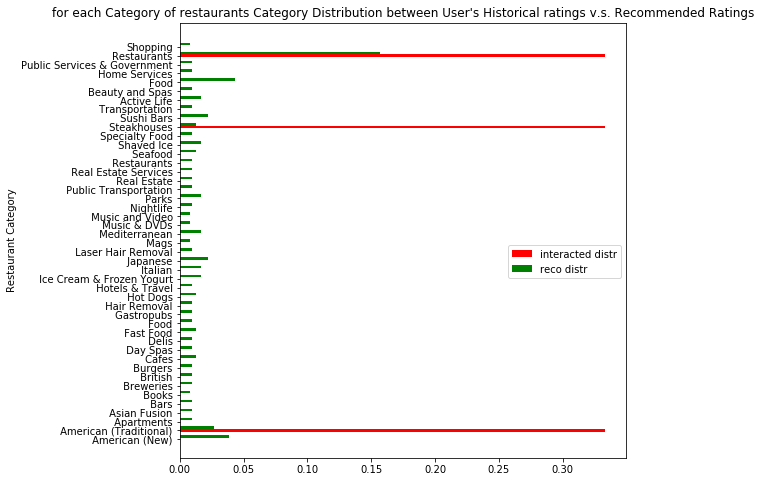

In [74]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['font.size'] = 10


def distr_comparison_plot(interacted_distr, reco_distr, width=0.3):
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index')
    reco = pd.DataFrame.from_dict(reco_distr, orient='index')
    df = interacted.join(reco, how='outer', lsuffix='_interacted')

    n = df.shape[0]
    index = np.arange(n)
    plt.barh(index, df['0_interacted'], height=width, label='interacted distr',color ='red')
    plt.barh(index + width, df['0'], height=width, label='reco distr',color ='green')
    plt.yticks(index, df.index)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title("for each Category of restaurants Category Distribution between User's Historical ratings v.s. Recommended Ratings")
    plt.ylabel('Restaurant Category')
    plt.show()
    
    
distr_comparison_plot(interacted_distr, reco_distr)

In [75]:
def compute_kl_divergence(interacted_distr, reco_distr, alpha=0.01):
    """
    KL (p || q), the lower the better.

    alpha is not really a tuning parameter, it's just there to make the
    computation more numerically stable. 
    Lower value of alpha worked well so using lower value of alpha i.e. 0.01 through out all experiments
    """
    kl_div = 0.
    for category, score in interacted_distr.items():
        reco_score = reco_distr.get(category, 0.)
        reco_score = (1 - alpha) * reco_score + alpha * score
        kl_div += score * np.log2(score / reco_score)

    return kl_div


print("KL divergence between interated/rated category of restaurants and recommendated category of restaurants:\n",compute_kl_divergence(interacted_distr, reco_distr, 0.01))


KL divergence between interated/rated category of restaurants and recommendated category of restaurants:
 2.9636122318059757


In [76]:
def generate_item_candidates(model, user_item, user_id, index2item, item_mapping,
                             filter_already_liked_items=True):
    """
    For a given user, generate the list of items that we can recommend, during this
    step, we will also attach the recommender's score to each item.
    """
    n_items = user_item.shape[1]
    
    # this is how implicit's matrix factorization generates
    # the scores for each item for a given user, modify this
    # part of the logic if we were to use a completely different
    # algorithm to generate the ranked items
    user_factor = model.user_factors[user_id]
    scores = model.item_factors.dot(user_factor)

    liked = set()
    if filter_already_liked_items:
        liked = set(user_item[user_id].indices)

    item_ids = set(np.arange(n_items))
    item_ids -= liked

    items = []
    for item_id in item_ids:
        item = item_mapping[index2item[item_id]]
        item.score = scores[item_id]
        items.append(item)

    return items

In [77]:
#re-ranking the predicted list of a recommender system in a post-processing step
items = generate_item_candidates(bpr, user_item_train, user_id, index2item, item_mapping)
print('number of item candidates:', len(items))
items[:10]

number of item candidates: 2766


[pbEiXam9YJL3neCYHGwLUA,
 HOJqzz1WvOmeR9oESJ4d9A,
 AkfSndWBxnTn-LpmiL8aLA,
 WBU0yq9J8qiYQfI_fh2P1Q,
 bNXpwTSavHBV9zBk2lUlGA,
 boE4Ahsssqic7o5wQLI04w,
 IuFEm-19YYh49T5ZlvwkDA,
 oEFJ29zAQaCNnQzebHQvpg,
 jGiKIJCVLZHXQDSNnSLPsw,
 F7IQngaDDBgYvhA3U31q-g]

In [78]:
def compute_utility(reco_items, interacted_distr, lmbda=0.99):
    """
    Our objective function for computing the utility score for
    the list of recommended items.

    lmbda : float, 0.0 ~ 1.0, default 0.5
        Lambda term controls the score and calibration tradeoff,
        the higher the lambda the higher the resulting recommendation
        will be calibrated. Lambda is keyword in Python, so it's
        lmbda instead ^^
    """
    reco_distr = compute_category_distr(reco_items)
    kl_div = compute_kl_divergence(interacted_distr, reco_distr)

    total_score = 0.0
    for item in reco_items:
        total_score += item.score
    
    # kl divergence is the lower the better, while score is
    # the higher the better so remember to negate it in the calculation
    utility = (1 - lmbda) * total_score - lmbda * kl_div
    return utility

In [79]:
def calib_recommend(items, interacted_distr, topn=10, lmbda=0.99):
    """
    start with an empty recommendation list, for topn cardinality, during each iteration
    update the list with the item that maximizes the utility function.
    """
    calib_reco = []
    for _ in range(topn):
        max_utility = -np.inf
        for item in items:
            if item in calib_reco:
                continue

            utility = compute_utility(calib_reco + [item], interacted_distr, lmbda)
            if utility > max_utility:
                max_utility = utility
                best_item = item

        calib_reco.append(best_item)
        
    return calib_reco

In [80]:
calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda=0.99)

In [81]:
print("top 10 calibrated recommendation of restaurants for test user are:\n")
calib_reco_items

top 10 calibrated recommendation of restaurants for test user are:



[nS0liS2vfKpxk5XyBLszzA,
 rnjz2KNgsQ2YaC_kjeuuAQ,
 YZPip_2JEd5DbG1RmiJhoA,
 UH881XoEcglrE1NR7dhr9w,
 d6UbRb9W5eA1yL-DuVZ8ug,
 wFkuCJ1GPR7z8pYo_doSUA,
 cEVUninwZ9ltNdIfdtpaiA,
 n-mj6IJkWyCu4BuD2dvm0A,
 ykvr3ib1gHQHI4tznSn8iA,
 Pcg4FtfbvSMMwrYuE1yVjQ,
 dMEr_XitO-5S_ezNC6EYZQ,
 Xug2kZTb_nftodx15BM4rQ,
 -PlOl5YoQn9aTglBOiSJ8Q,
 iHTf00VF1vBgRbKQOzAiQQ,
 fJhF5Yy4nguguaaH3TabmQ,
 7UEkwYw2ryHYRVnlZ1EG4Q,
 cFj5shMfBYALFxtZuB38Sg,
 dMlsQsPU8Y_oiPYC5hHi2A,
 Gw8BSjJ6FFppeghWUv-DGA,
 Psfe1Lnwkm8hzcVq80TwQw]

In [82]:
calib_reco_distr = compute_category_distr(calib_reco_items)
calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
print('calibrated reco kl-divergence score:', calib_reco_kl_div)


calibrated reco kl-divergence score: 0.406350290905862


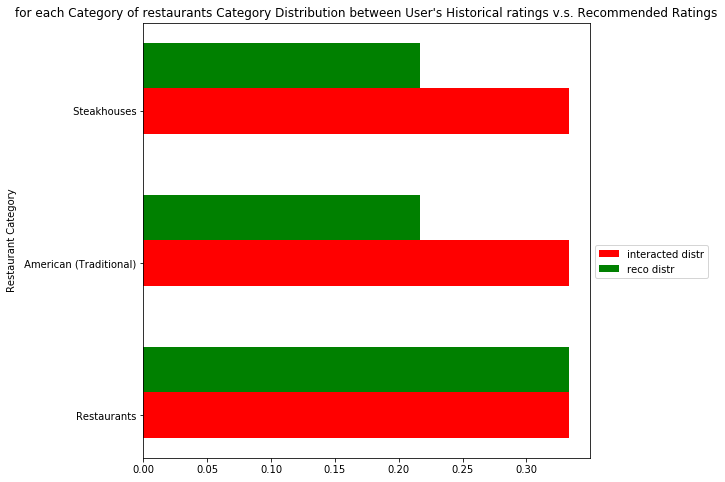

In [83]:
calib_reco_distr = compute_category_distr(calib_reco_items)
distr_comparison_plot(interacted_distr, calib_reco_distr)

for value of lambda= 0.99
calibrated reco kl-divergence score: 0.33000434345242896


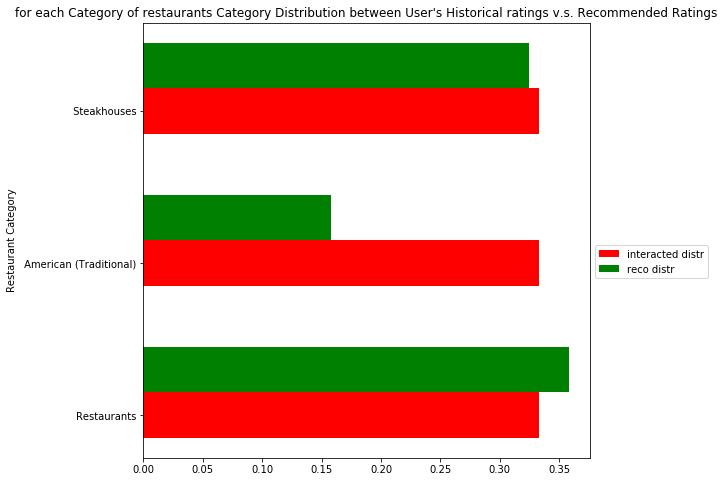

original reco kl-divergence score: 3.6080725311227257


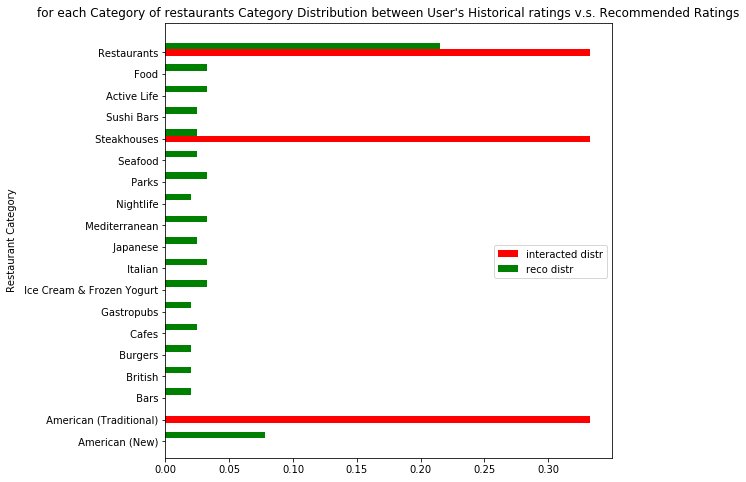

-----------------------------------------------------------------------------------------------------------------------
for value of lambda= 0.8
calibrated reco kl-divergence score: 0.3748094058687277


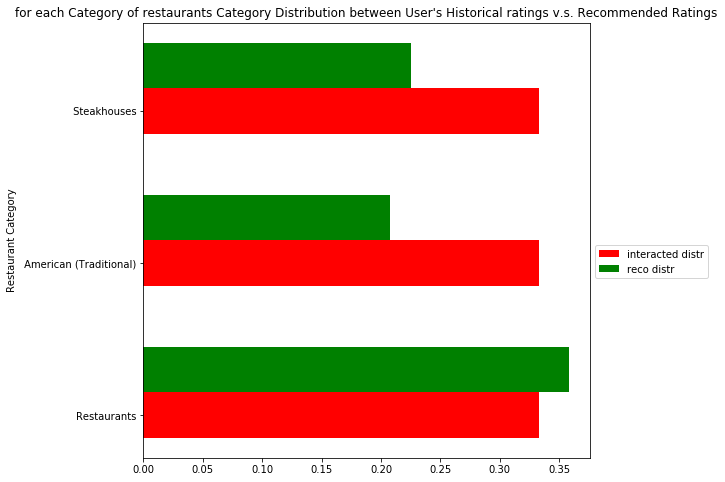

original reco kl-divergence score: 3.6080725311227257


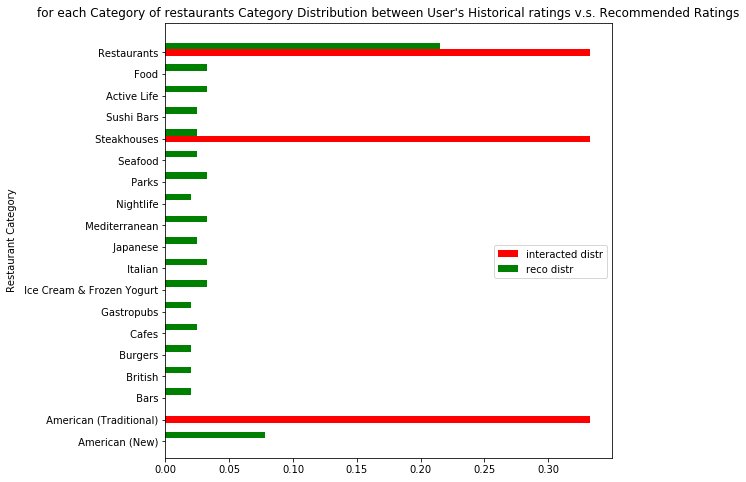

-----------------------------------------------------------------------------------------------------------------------
for value of lambda= 0.75
calibrated reco kl-divergence score: 0.4352844724298802


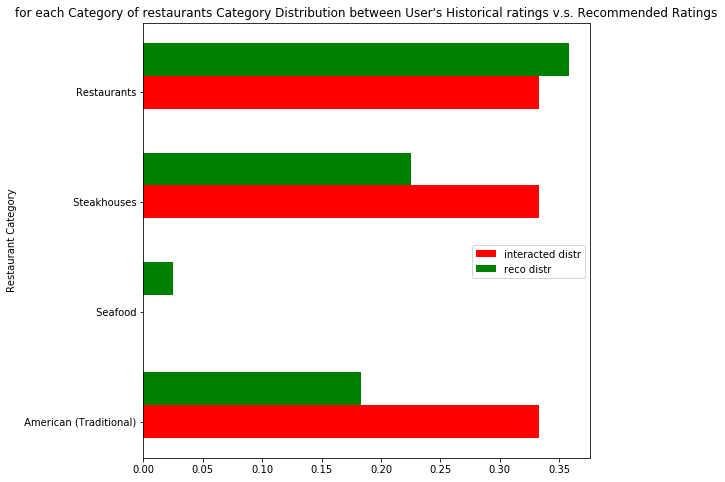

original reco kl-divergence score: 3.6080725311227257


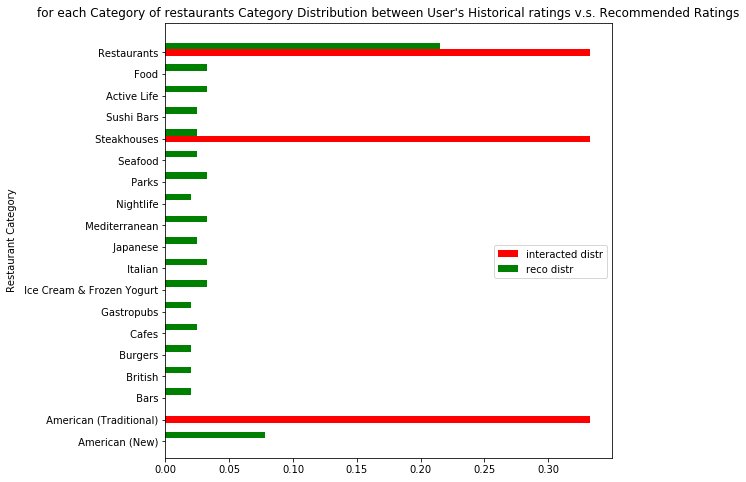

-----------------------------------------------------------------------------------------------------------------------
for value of lambda= 0.5
calibrated reco kl-divergence score: 0.7648658173407298


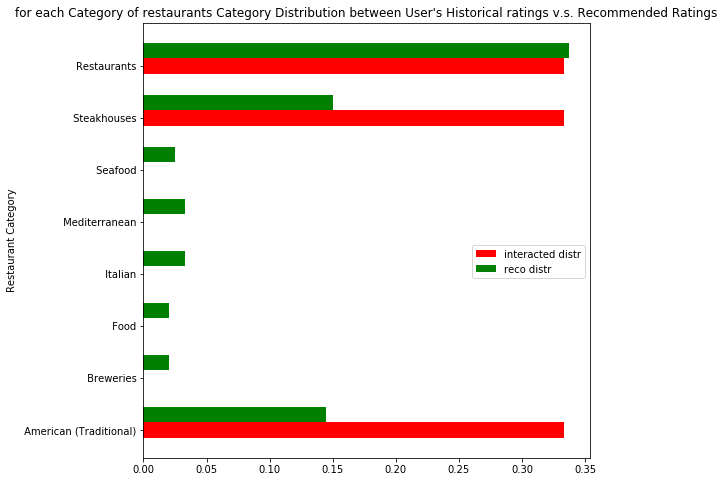

original reco kl-divergence score: 3.6080725311227257


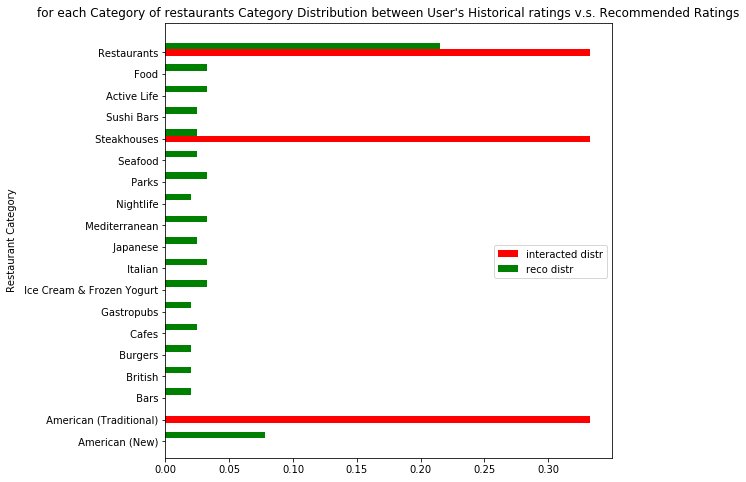

-----------------------------------------------------------------------------------------------------------------------


In [99]:
lambdaValues=[0.99,0.80,0.75,0.50]
resultsorigininal=[]
resultsCF=[]
resultsorigininalreco=[]
resultsCFreco=[]
for l in lambdaValues:
    topn = 10
    user_id = 1650
    
    print("for value of lambda=",l)
    reco = bpr.recommend(user_id, user_item_train, N=topn)
    reco_items = [item_mapping[index2item[index]] for index, _ in reco]
    reco_distr = compute_category_distr(reco_items)

    interacted_ids = user_item_train[user_id].nonzero()[1]
    interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
    interacted_distr = compute_category_distr(interacted_items)

    items = generate_item_candidates(bpr, user_item_train, user_id, index2item, item_mapping)
    calib_reco_items = calib_recommend(items, interacted_distr, topn, l)
    calib_reco_distr = compute_category_distr(calib_reco_items)

    calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
    print('calibrated reco kl-divergence score:', calib_reco_kl_div)
    distr_comparison_plot(interacted_distr, calib_reco_distr)
    resultsCF.append(calib_reco_kl_div)
    
    
    reco_kl_div = compute_kl_divergence(interacted_distr, reco_distr)
    print('original reco kl-divergence score:', reco_kl_div)
    distr_comparison_plot(interacted_distr, reco_distr)
    resultsorigininal.append(reco_kl_div)
    
    print("-----------------------------------------------------------------------------------------------------------------------")

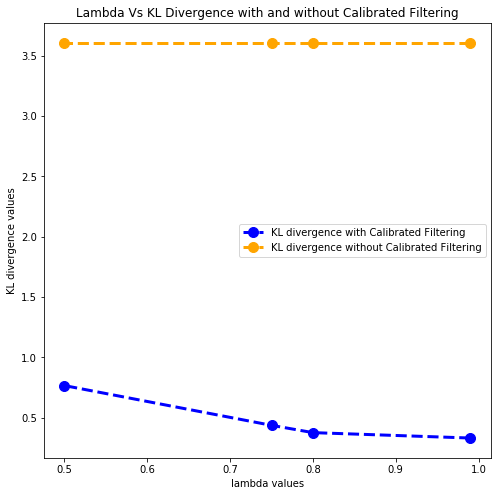

following are the tabular format of our results which shows we got better values of KL Divergence for Calibrated Filtering with Maximum value of lambda(0.99) and min value of alpha(0.01):


lambda Values,alpha values,KL divergence with Calibrated Filtering**,KL divergence without Calibrated Filtering
float64,float64,float64,float64
0.99,0.01,0.33000434345242896,3.6080725311227257
0.8,0.01,0.3748094058687277,3.6080725311227257
0.75,0.01,0.4352844724298802,3.6080725311227257
0.5,0.01,0.7648658173407298,3.6080725311227257


In [124]:
#Lambda Vs KL Divergence with and without Calibrated Filtering

x_data=resultsCF
y_data=resultsorigininal

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(lambdaValues,x_data,label='KL divergence with Calibrated Filtering',color='blue', marker='o', linestyle='dashed',linewidth=3, markersize=10)
ax.plot(lambdaValues,y_data,label='KL divergence without Calibrated Filtering',color='orange', marker='o', linestyle='dashed',linewidth=3, markersize=10)

ax.set_xlabel('lambda values')
ax.set_ylabel('KL divergence values')
plt.legend()
plt.title("Lambda Vs KL Divergence with and without Calibrated Filtering")
plt.show()

#tabular result format

print("following are the tabular format of our results which shows we got better values of KL Divergence for Calibrated Filtering with Maximum value of lambda(0.99) and min value of alpha(0.01):")
t = Table()
a = lambdaValues
b = [0.01,0.01,0.01,0.01]
c = x_data
d = y_data
t = Table([a, b, c, d],names=('lambda Values', 'alpha values', 'KL divergence with Calibrated Filtering**','KL divergence without Calibrated Filtering'))
t